**@author: James V. Talwar**

# Discovery Set Analysis: Covariates and Associations with Melanoma Age of Diagnosis

**About**: This notebook provides the code needed to generate **Supplementary Figure 5 A-E** from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses evaluated covariates and associations with melanoma age of diagnosis in skin cutaneous melanoma (SKCM) cases in the TCGA. Covariates investigated here include sex, mutation burden, UV-associated mutational signatures, and the inclusion of HLA-A*02:01 in AI allele carrier status.


## 1. Import Packages; Load and Format Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, Mutation Burden, etc.):

In [3]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

#Add column for "expanded" AI carrier status that includes HLA-A02:01
tcgaSummary["AIOrA0201"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles.union({"HLA-A02:01"}))) > 0) for i,row in tcgaSummary.iterrows()]

Load in TCGA mutational signatures:

In [4]:
mutationalSignatures = pd.read_excel("../GenotypeData/TCGA_WES_signatures_in_samples.xlsx")
mutationalSignatures = mutationalSignatures[mutationalSignatures["Cancer Types"] == "Skin-Melanoma"][["Cancer Types", "Sample Names", "SBS5","SBS6","SBS7a","SBS7b","SBS7c","SBS7d"]]
mutationalSignatures.index = [el[:12] for el in mutationalSignatures["Sample Names"]] #reindex with TCGA indexes
mutationalSignatures["UV_Exposure"] = [sum(row["SBS7a":]) for i,row in mutationalSignatures.iterrows()]

## 2. Run Analyses and Generate Figures:

### 2a. Supplementary Figure 5A: Sex and Age of Diagnosis

Is there a significant difference in age of diagnosis between males and females?

In [5]:
_, p = mannwhitneyu(tcgaSummary[tcgaSummary.Sex == "male"].Age, tcgaSummary[tcgaSummary.Sex == "female"].Age)
medianSexAgeDiff = np.median(tcgaSummary[tcgaSummary.Sex == "female"].Age) - np.median(tcgaSummary[tcgaSummary.Sex == "male"].Age)

print("p = {0:.3f}; Median Age Difference {1}".format(p, medianSexAgeDiff))

p = 0.247; Median Age Difference 1.0


Generate Figure:

([<matplotlib.axis.XTick at 0x15552009d4e0>,
 [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

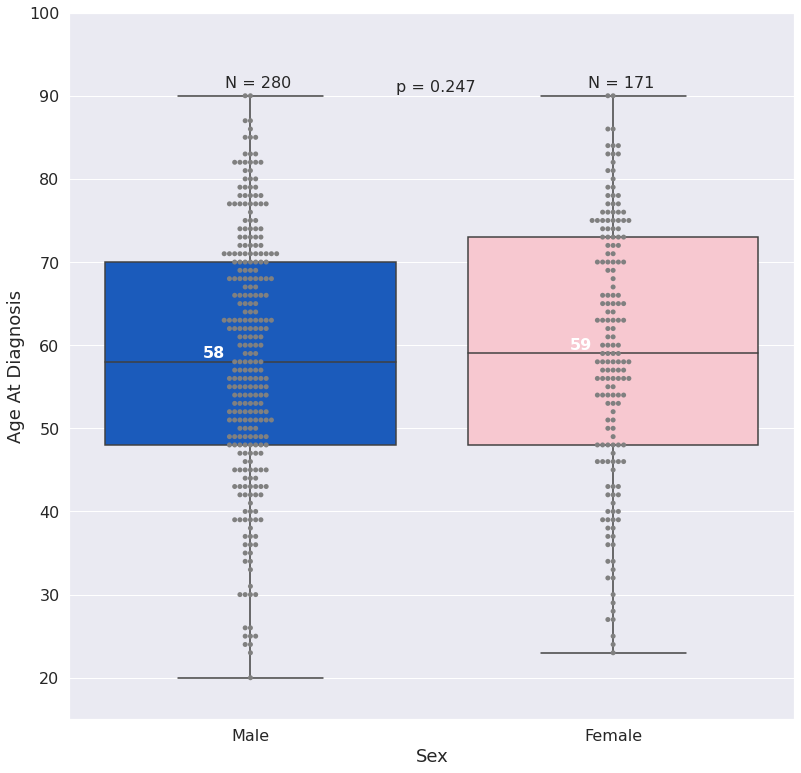

In [6]:
colorMeImpressed = {"male":'#0056D6' , "female":"#FFC0CB"} #palette for color by sex 
sns.set(font_scale = 1.1)
plt.figure(figsize=(13,13))
sns.boxplot(data = tcgaSummary, x = "Sex", y = "Age", palette = colorMeImpressed)
sns.swarmplot(data = tcgaSummary, x = "Sex", y = "Age", color = "grey")

plt.text(0.4, 90.5, "p = %.3f" % p, fontsize = 16)
plt.ylim(15,100)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Age At Diagnosis", fontsize = 18)
plt.xlabel("Sex", fontsize = 18)

plt.text(0.93, 91, f'N = {tcgaSummary.Sex.value_counts()["female"]}', fontsize=16)
plt.text(-0.07, 91, f'N = {tcgaSummary.Sex.value_counts()["male"]}', fontsize=16)
plt.text(-0.13, 58.5, int(np.median(tcgaSummary[tcgaSummary.Sex == "male"].Age)), fontsize = 16, color= "white", weight = "bold")
plt.text(0.88, 59.5, int(np.median(tcgaSummary[tcgaSummary.Sex == "female"].Age)), fontsize = 16, color= "white", weight = "bold")


plt.xticks([0, 1], ["Male", "Female"])

In [7]:
np.median(tcgaSummary[tcgaSummary.Sex == "male"].Age)

58.0

In [8]:
np.median(tcgaSummary[tcgaSummary.Sex == "female"].Age)

59.0

### 2b. Supplementary Figure 5D: Mutation burden and AI Carrier Status (with and without HLA-A*02:01)

Are there significant mutation burden differences between MHC-I AI allele carriers and non-carriers?

In [9]:
_, pMutBurden = mannwhitneyu(tcgaSummary[tcgaSummary.HasProtection].NumberMutations, tcgaSummary[~tcgaSummary.HasProtection].NumberMutations)
_, pMutBurdenA2Included = mannwhitneyu(tcgaSummary[tcgaSummary.AIOrA0201].NumberMutations, tcgaSummary[~tcgaSummary.AIOrA0201].NumberMutations)

print("Mutation Burden (HLA-A*02:01 excluded) p = {0:.3f}".format(pMutBurden))
print("Mutation Burden (HLA-A*02:01 included) p = {0:.3f}".format(pMutBurdenA2Included))

Mutation Burden (HLA-A*02:01 excluded) p = 0.352
Mutation Burden (HLA-A*02:01 included) p = 0.365


Reformat dataframe(s) for visualization/plotting compatibility:

In [10]:
#HLA-A*02:01 excluded:
autoimmuneSubframe = tcgaSummary.copy()
autoimmuneSubframe = autoimmuneSubframe.drop(["AIOrA0201"], axis = 1)
autoimmuneSubframe["AlleleSet"] = ["Has Autoimmune Allele (A*02:01 Excluded)" for i in autoimmuneSubframe.index]

#HLA-A*02 included:
a2Included = tcgaSummary.copy()
a2Included = a2Included.drop(["HasProtection"], axis = 1)
a2Included = a2Included.rename(columns = {"AIOrA0201":"HasProtection"})
a2Included["AlleleSet"] = ["Has Autoimmune Allele (A*02:01 Included)" for i in a2Included.index]

#concatenate dataframes:
mutationBurdenVisualizationDF = pd.concat([autoimmuneSubframe, a2Included])

Generate Figure:

Text(0.9, 1009, 'p = 0.365')

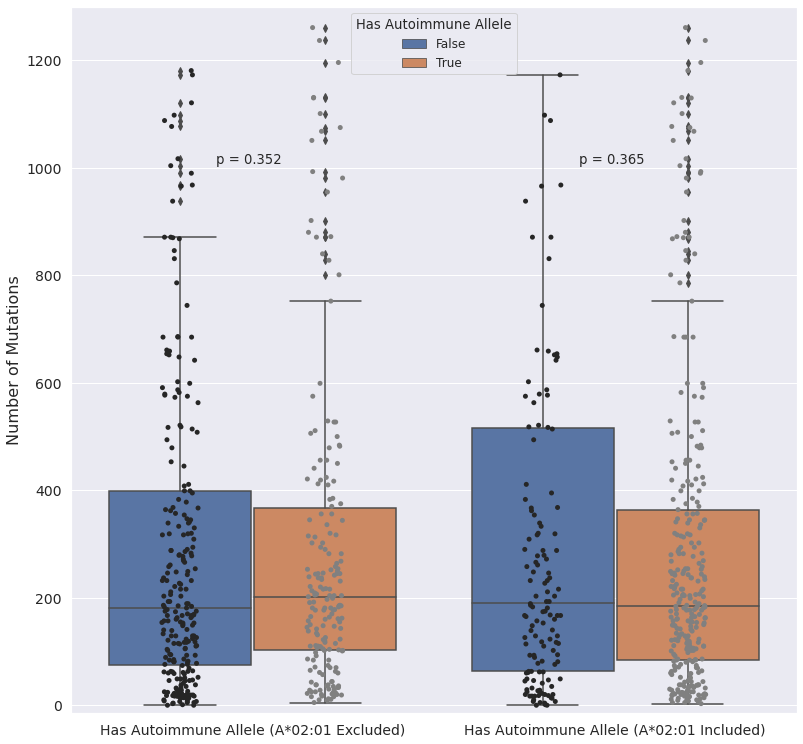

In [11]:
plt.figure(figsize = (13,13))
ax = sns.boxplot(data = mutationBurdenVisualizationDF,  x = "AlleleSet" , y = "NumberMutations", hue = "HasProtection")
sns.stripplot(data = mutationBurdenVisualizationDF,  x = "AlleleSet" , y = "NumberMutations", hue = "HasProtection", dodge = True, color = "grey")

plt.ylim(-15,1300)
plt.xlabel("")
plt.ylabel("Number of Mutations", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", loc = "upper center")

plt.text(-0.1, 1009, "p = %.3f" % pMutBurden)
plt.text(0.9, 1009, "p = %.3f" % pMutBurdenA2Included)

### 2c. Supplementary Figure 5C: UV-Associated Mutational Signatures and AI Carrier Status (with and without HLA-A*02:01)

Add autoimmune status (both with and without HLA-A*02:01) and mutation burden to mutational signatures dataframe: 

In [12]:
#get the intersection of individuals with mutational signatures information and in tcgaSummary:
mutationalSignatures = mutationalSignatures[mutationalSignatures.index.isin(tcgaSummary.index)]

#add needed information for downstream analyses
mutationalSignatures["HasProtection"] = [tcgaSummary.loc[i, "HasProtection"] for i in mutationalSignatures.index]
mutationalSignatures["AIOrA0201"] = [tcgaSummary.loc[i, "AIOrA0201"] for i in mutationalSignatures.index]
mutationalSignatures["NumberMutations"] = [tcgaSummary.loc[i, "NumberMutations"] for i in mutationalSignatures.index]

Are there significant UV-Associated mutational signature differences between MHC-I AI allele carriers and non-carriers?

In [13]:
_, pMutSigs = mannwhitneyu(mutationalSignatures[mutationalSignatures.HasProtection].UV_Exposure, mutationalSignatures[~mutationalSignatures.HasProtection].UV_Exposure)
_, pMutSigsA2Included = mannwhitneyu(mutationalSignatures[mutationalSignatures.AIOrA0201].UV_Exposure, mutationalSignatures[~mutationalSignatures.AIOrA0201].UV_Exposure)

print("Mutation Burden (HLA-A*02:01 excluded) p = {0:.3f}".format(pMutSigs))
print("Mutation Burden (HLA-A*02:01 included) p = {0:.3f}".format(pMutSigsA2Included))

Mutation Burden (HLA-A*02:01 excluded) p = 0.415
Mutation Burden (HLA-A*02:01 included) p = 0.186


Reformat dataframe(s) for visualization/plotting compatibility:

In [14]:
#HLA-A*02:01 excluded:
autoimmuneSubframe = mutationalSignatures.copy()
autoimmuneSubframe = autoimmuneSubframe.drop(["AIOrA0201"], axis = 1)
autoimmuneSubframe["AlleleSet"] = ["Has Autoimmune Allele (A*02:01 Excluded)" for i in autoimmuneSubframe.index]

#HLA-A*02 included:
a2Included = mutationalSignatures.copy()
a2Included = a2Included.drop(["HasProtection"], axis = 1)
a2Included = a2Included.rename(columns = {"AIOrA0201":"HasProtection"})
a2Included["AlleleSet"] = ["Has Autoimmune Allele (A*02:01 Included)" for i in a2Included.index]

#concatenate dataframes:
mutSigsVisualizationDF = pd.concat([autoimmuneSubframe, a2Included])

Generate Figure:

Text(0.9, 2518, 'p = 0.186')

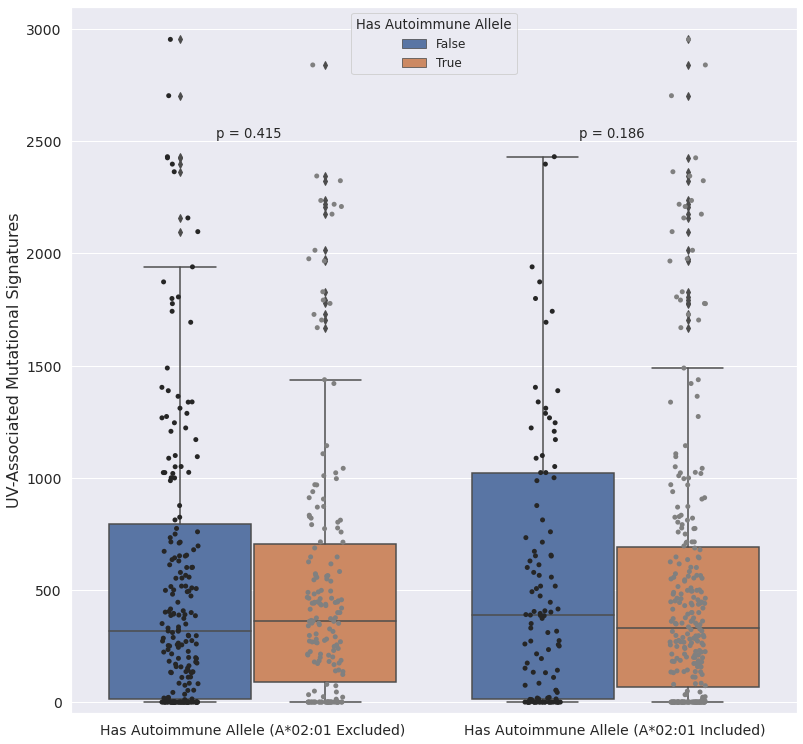

In [15]:
plt.figure(figsize = (13,13))
ax = sns.boxplot(data = mutSigsVisualizationDF,  x = "AlleleSet", y = "UV_Exposure", hue = "HasProtection")
sns.stripplot(data = mutSigsVisualizationDF,  x = "AlleleSet", y = "UV_Exposure", hue = "HasProtection", dodge = True, color = "grey")
plt.ylim(-50,3100)
plt.xlabel("")
plt.ylabel("UV-Associated Mutational Signatures", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title = "Has Autoimmune Allele", loc = "upper center")

plt.text(-0.1, 2518, "p = %.3f" % pMutSigs)
plt.text(0.9, 2518, "p = %.3f" % pMutSigsA2Included)

### 2d. Supplementary Figure 5B: Correlation between Tumor Mutation Burden and UV-associated Mutational Signatures

Run Pearson correlation between variables:

In [16]:
r2d2, _ = pearsonr(mutationalSignatures.NumberMutations, mutationalSignatures.UV_Exposure)
print("Pearson correlation between TMB and UV-associated mutational signatures: {0:.3f}".format(r2d2))

Pearson correlation between TMB and UV-associated mutational signatures: 0.984


Generate Figure:

(-50.0, 4000.0)

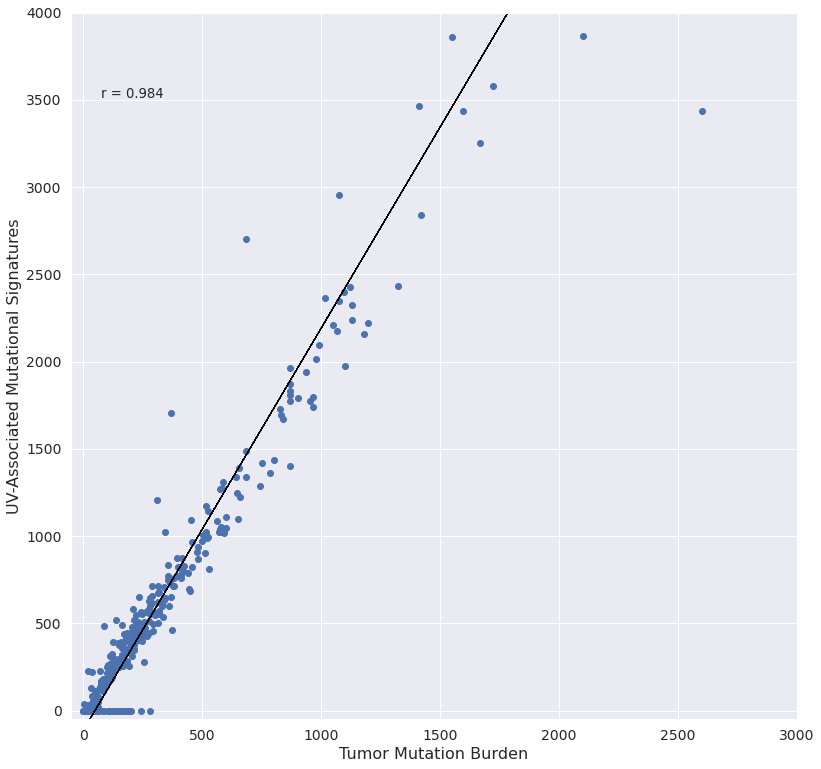

In [17]:
plt.figure(figsize = (13,13))
plt.scatter(mutationalSignatures.NumberMutations, mutationalSignatures.UV_Exposure)
m,b = np.polyfit(mutationalSignatures.NumberMutations, mutationalSignatures.UV_Exposure, 1)

plt.plot(mutationalSignatures.NumberMutations, b + m*np.array(mutationalSignatures.NumberMutations), '-', color = "black", linewidth = 0.8)
plt.text(75, 3513 ,"r = {0:.3f}".format(r2d2))
plt.ylabel("UV-Associated Mutational Signatures", fontsize = 16)
plt.xlabel("Tumor Mutation Burden", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-50, 3000)
plt.ylim(-50, 4000)

### 2e. Supplementary Figure 5E: Inclusion of HLA-A*02:01 in AI Carrier Status

How common is HLA-A*02:01?

In [18]:
alleleCountA0201 = 0
for i, row in tcgaSummary.iterrows():
    if row["A1"] == "HLA-A02:01":
        alleleCountA0201 += 1
    if row["A2"] == "HLA-A02:01":
        alleleCountA0201 += 1
        
print("Number of individuals in SKCM TCGA with HLA-A*02:01: {}".format(tcgaSummary[(tcgaSummary.A1 == "HLA-A02:01") | (tcgaSummary.A2 == "HLA-A02:01")].shape[0]))
print("Allele incidence of HLA-A*02:01 in SKCM TCGA: {}".format(alleleCountA0201))
print("Allele frequency of HLA-A*02:01 in SKCM TCGA: {0:.2f}%".format(alleleCountA0201*100/(2*tcgaSummary.shape[0])))

Number of individuals in SKCM TCGA with HLA-A*02:01: 201
Allele incidence of HLA-A*02:01 in SKCM TCGA: 237
Allele frequency of HLA-A*02:01 in SKCM TCGA: 26.27%


Does inclusion of HLA-A*02:01 in autoimmune carrier status significantly associate with age?

In [19]:
_, p = mannwhitneyu(tcgaSummary[tcgaSummary.AIOrA0201].Age, tcgaSummary[~tcgaSummary.AIOrA0201].Age)
medianAgeDifference = np.median(tcgaSummary[tcgaSummary.AIOrA0201].Age) - np.median(tcgaSummary[~tcgaSummary.AIOrA0201].Age)

print("p = {0:.3f}; Median Age Difference {1}".format(p, medianAgeDifference))

p = 0.316; Median Age Difference 1.5


Generate Figure:

Text(0.85, 59.5, '59.0')

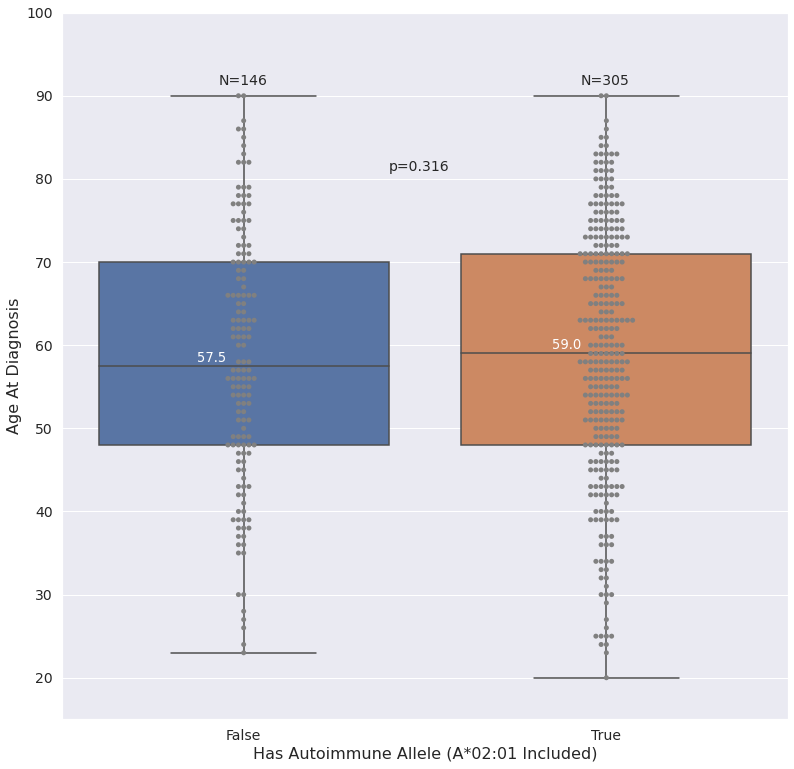

In [20]:
plt.figure(figsize=(13,13))
sns.boxplot(data = tcgaSummary, x = "AIOrA0201", y = "Age")
sns.swarmplot(data = tcgaSummary, x = "AIOrA0201", y = "Age", color = "grey")

plt.ylabel("Age At Diagnosis", fontsize = 16)
plt.xlabel("Has Autoimmune Allele (A*02:01 Included)", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(15,100)
plt.text(0.93, 91.3, "N={}".format(tcgaSummary[tcgaSummary.AIOrA0201].shape[0]), fontsize = 14)
plt.text(-0.07, 91.3, "N={}".format(tcgaSummary[~tcgaSummary.AIOrA0201].shape[0]), fontsize = 14)

plt.text(0.4, 81, "p={0:.3f}".format(p), fontsize = 14)
plt.text(-.13, 58, str(np.median(tcgaSummary[~tcgaSummary.AIOrA0201].Age)), color = "white")
plt.text(0.85, 59.5, str(np.median(tcgaSummary[tcgaSummary.AIOrA0201].Age)), color = "white")